In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import RandomOverSampler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Functions
- The cell below holds functions that I have designed.
I would usually store them within a script saved in /src but for the sake of this project I will 
store them in the below cell.

In [58]:
def plot_histogram(df, column, bins=30):
    plt.figure(figsize=(8,5))
    plt.hist(df[column].dropna(), bins=bins, edgecolor='black', alpha=0.7)
    plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

def calculate_proportions(df, column_name):
    proportions = df[column_name].value_counts(normalize=True).round(3).sort_index(ascending=True)
    return proportions

def split_data(df, test_size=0.2):
       ''' 
       This function splits the data into training and testing
       datasets without allowing any leakage of horses
       from the same race into either dataset.
       '''
       # Get unique races
       unique_races = df['race_id'].unique()
        
       # Split the races into train and test sets
       train_races, test_races = train_test_split(unique_races, test_size=test_size, shuffle=True, random_state=42)
        
       # Split the dataframe based on the race ids
       train_data = df[df['race_id'].isin(train_races)]
       test_data = df[df['race_id'].isin(test_races)]
        
       return train_data, test_data

def eval_classification_model(test_target, predictions):
    # Evaluate the model
    accuracy = accuracy_score(test_target, predictions)
    precision = precision_score(test_target, predictions)
    recall = recall_score(test_target, predictions)
    f1 = f1_score(test_target, predictions)
    roc_auc = roc_auc_score(test_target, predictions)
    conf_matrix = confusion_matrix(test_target, predictions)
    # [[True Negatives, False Positives], 
    #    [False Negatives, True Positives]]

    return accuracy, precision, recall, f1, roc_auc, conf_matrix

def print_metrics(test_target, predictions):
    accuracy, precision, recall, f1, roc_auc, conf_matrix = eval_classification_model(test_target, predictions)
    
    print(f"\nConfusion Matrix: \n{conf_matrix}")
    print(f"Accuracy: {accuracy}")
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 score: {f1}')
    print(f'ROC AUC score: {roc_auc}')

def profit_calculation(df, stake = 1):
    """
    Calculate ROI, total returns from the model predictions.

    Args:
        df (pd.Dataframe): A dataframe that has a column holding the model predictions
        stake (int): The amount staked for each bet

    Returns:
        print() 
    """
    # Filter rows where model_preds == 1
    bets = df[df['model_preds'] == 1].copy()

    # Calculate returns
    bets['Return'] = bets.apply(
        lambda row: (row['obs__bsp'] - 1) * stake if row['obs__is_winner'] == 1 else -1,
        axis=1
    )

    # Total return
    total_return = bets['Return'].sum()

    # total number of bets
    total_bets = len(bets)

    # Calculate accuracy: Percentage of correct predictions where the model predicted 1 and won
    correct_predictions = bets[bets['obs__is_winner'] == 1].shape[0]

    if total_bets > 0:
        accuracy = (correct_predictions / total_bets) * 100  # Accuracy in percentage
        return_per_pound = total_return / (total_bets * stake)
    else:
        accuracy = 0
        return_per_pound = 0

    print(f"Total number of bets: {total_bets}")
    print(f"Total return from betting £{stake:.2f} on each prediction where model_preds == 1: £{total_return:.2f}")
    print(f"Return per pound invested: £{return_per_pound:.2f}")
    print(f"Model accuracy: {accuracy:.2f}%")

def monte_carlo_simulation(df, feature_cols, n_sims=200, test_frac=0.2):
    roi_results = []

    for i in range(n_sims):
        # Sample races to avoid leakage
        sampled_races = df['race_id'].sample(frac=0.7, replace=True, random_state=i)
        sim_df = df[df['race_id'].isin(sampled_races)]

        X = sim_df[feature_cols]
        y = sim_df['obs__is_winner']

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_frac, stratify=y, random_state=i
        )

        model = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=i)
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_test)[:, 1]

        # attach preds
        sim_df_test = sim_df.loc[X_test.index].copy()
        sim_df_test['pred_prob'] = probs

        # Bet £1 on top predicted horse in each race
        bets = sim_df_test.loc[sim_df_test.groupby('race_id')['pred_prob'].idxmax()]

        # Returns: win → (bsp - 1), lose → -1
        bets['bet_return'] = np.where(
            bets['obs__is_winner'] == 1,
            bets['obs__bsp'] - 1,
            -1
        )

        roi = bets['bet_return'].mean()
        roi_results.append(roi)

    return np.mean(roi_results), np.std(roi_results), roi_results

In [3]:
df = pd.read_csv('test_dataset.csv')
df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53


## Initial EDA
- check for Nan's
- Check for outliers in the data

In [4]:
df.dtypes

date                        object
racecourse_country          object
racecourse_name             object
race_time                   object
race_id                      int64
race_distance              float64
race_type                   object
race_type_simple            object
going_clean                 object
n_runners                    int64
horse_id                     int64
horse_name                  object
age                          int64
official_rating            float64
carried_weight             float64
draw                         int64
jockey_id                    int64
jockey_name                 object
trainer_id                   int64
trainer_name                object
ltp_5min                   float64
obs__bsp                   float64
obs__racing_post_rating    float64
obs__Place                  object
obs__uposition               int64
obs__is_winner               int64
obs__top_speed             float64
obs__distance_to_winner    float64
obs__pos_prize      

In [5]:
# check for NaN's
# nan_counts = df.isna().sum
# print(nan_counts)

In [6]:
# returns a list of unique values
df["draw"].value_counts().head(10)

draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

In [7]:
# returns a list of unique values
df["draw"].value_counts().head(10)


draw
0    316024
3     44689
2     44624
1     44624
4     44359
5     43663
6     41756
7     38632
8     34433
9     29517
Name: count, dtype: int64

We can see that there is a high number of values with a draw value of 0. From my experience draw values are 1 or greater (for flat races).
This warrants further investigation as 'Draw' is known to have a major impact on the probabilities 
of horses winning at particular tracks and particular distances in flat races.

We are going to investigate if any flat races are affected by 'draw' == 0.

In [8]:
# Group by race_id and race_type_simple, then check if any draw == 0 in that race
draw_zero_races = (
    df.groupby(['race_id', 'race_type_simple'])['draw']
      .apply(lambda x: (x == 0).any())
      .reset_index(name='has_draw_zero')
)

# Now see which race types have races with draw == 0
draw_zero_counts = draw_zero_races.groupby('race_type_simple')['has_draw_zero'].sum().sort_values(ascending=False)
print(draw_zero_counts)

race_type_simple
Hurdle       18471
Chase        12055
Flat Turf     3075
Flat AW        174
Name: has_draw_zero, dtype: int64


### Display a histogram showing counts of field sizes.

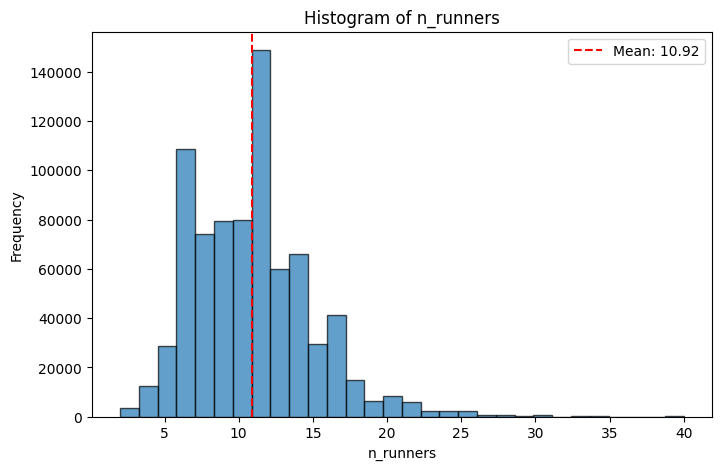

In [10]:
plot_histogram(df, "n_runners")


### Display a histogram showing counts of age of runners.

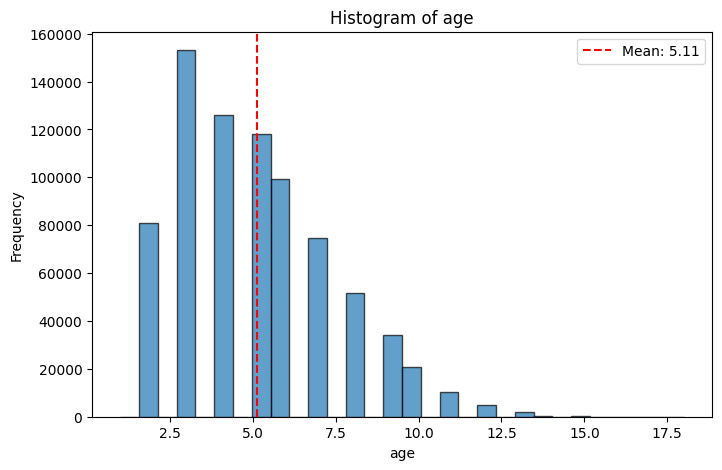

In [11]:
plot_histogram(df,'age')

## Data Cleaning and Feature Engineering

With the numeric columns, it is essential that there are no NaN values.
With the numeric columns all NaN's will be replaced with 0.

In [12]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

I am going to create a feature called draw_iv. This feature is used to show the impact value of a draw
by 'racecourse_name', 'race_distance', 'race_type' and 'going_clean'. I have done this as previous analysis
has shown the significant impact on stall number for flat races at particular racetracks.

Due to the large number of flat races where we don't have values for 'draw' I may not use this in the modelling 
but I felt it was an important area to highlight for this assessment.

In [13]:
# create a draw IV feature.

# Columns: racecourse_name, race_distance, race_type, going_clean, draw, obs__is_winner
group_cols = ['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw']

draw_stats = df.groupby(group_cols)['obs__is_winner'].agg(['sum', 'count']).reset_index()
draw_stats['win_pct'] = draw_stats['sum'] / draw_stats['count']

# Overall win rate per race conditions
overall_win_pct = df.groupby(['racecourse_name', 'race_distance', 'race_type', 'going_clean'])['obs__is_winner'].mean().reset_index()
overall_win_pct = overall_win_pct.rename(columns={'obs__is_winner':'overall_win_pct'})

# Merge with draw stats
draw_stats = draw_stats.merge(overall_win_pct, on=['racecourse_name', 'race_distance', 'race_type', 'going_clean'])
draw_stats['draw_iv'] = draw_stats['win_pct'] / draw_stats['overall_win_pct']

df = df.merge(draw_stats[['racecourse_name', 'race_distance', 'race_type', 'going_clean','draw', 'draw_iv']], 
              on=['racecourse_name', 'race_distance', 'race_type', 'going_clean', 'draw'], 
              how='left')

df[['date', 'race_time','racecourse_name', 'horse_name','draw', 'draw_iv']].head(10)

,date,race_time,racecourse_name,horse_name,draw,draw_iv
0,2015-05-01,13:40,Chepstow,Eton Rambler,3,0.000000
1,2015-05-01,13:40,Chepstow,Shades Of Silver,6,0.854545
2,2015-05-01,13:40,Chepstow,Marengo,8,0.000000
3,2015-05-01,13:40,Chepstow,Smoker,2,0.854545
4,2015-05-01,13:40,Chepstow,Symphony Of Kings,4,1.709091
5,2015-05-01,13:40,Chepstow,The Holyman,5,0.000000
6,2015-05-01,13:40,Chepstow,May Be Some Time,7,0.949495
7,2015-05-01,13:40,Chepstow,Air Squadron,1,1.553719
8,2015-05-01,13:50,Musselburgh,Copacobana,4,1.627614
9,2015-05-01,13:50,Musselburgh,Sadie Babes,3,0.969925


### Create rank columns
- I am going to create some features that are derived from existing features in the dataset that could be useful for 
creating models with greater powers of prediction.
- This allows us to use a horses relative rank in a model instead of it's absolute value,
this can be very useful when a horse is moving between classes.

### create a feature that indicates the rank of ltp_5min for each horse, race combination

In [14]:
df['ltp_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['ltp_5min']
    .rank(method='min', ascending=True)
)

### create a feature that indicates the rank of official_rating for each horse, race combination


In [15]:
df['rating_rank'] = (
    df.groupby(['date', 'racecourse_name', 'race_time'])['official_rating']
    .rank(method='min', ascending=False)
)

### Create a column that shows the career max speed achieved by a horse

In [16]:
# Store original index
df['original_index'] = df.index

# Ensure obs__top_speed NaNs are 0
df['obs__top_speed'] = df['obs__top_speed'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute max_top_speed_prev per horse
df['max_top_speed_prev'] = df.groupby('horse_id')['obs__top_speed'].transform(
    lambda s: s.shift(1).cummax().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)


### Calculate the amount of prize money won in previous starts.

In [17]:
# Store original index
df['original_index'] = df.index

# Ensure prize column has no NaNs
df['obs__pos_prize'] = df['obs__pos_prize'].fillna(0)

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative prize money per horse, excluding current race
df['horse_cum_prize_prev'] = df.groupby('horse_id')['obs__pos_prize'].transform(
    lambda s: s.shift(1).cumsum().fillna(0)
)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)

### Calculate the number of previous starts.

In [18]:
# Store original index
df['original_index'] = df.index

# Sort by horse and date
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative starts per horse, excluding current race
df['horse_cum_starts_prev'] = df.groupby('horse_id').cumcount().fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index']).reset_index(drop=True)


### Calculate the average prize money won per start
- This can help to compare horses that have run in different classes, 
for example a horse that has placed in class 1 vs a horse that has won in class 2.
- I believe this is an important metric to help determine the 'class' of a runner.

In [19]:
df['ave_prize_per_start'] = (df['horse_cum_prize_prev'] / df['horse_cum_starts_prev']).round().fillna(0)

### Calculate an avg. PRB metric
- PRB == percentage of rivals beaten.
- Very important to note that avg_prb is a historical measure, it is calculated on past performances.
- This helps us to understand the merits of unplaced runs, for example finishing 5 of 16 is a vastly 
different performance than finishing 5 of 6.

In [20]:
df['prb'] = (df['n_runners'] - df['obs__uposition']) / (df['n_runners'] - 1)

# Sort by horse and date to ensure correct cumulative calculation
df = df.sort_values(['horse_id', 'date'])

# Compute cumulative average PRB per horse, ignoring current race
df['avg_prb'] = df.groupby('horse_id')['prb'].transform(
    lambda x: x.shift(1).expanding().mean().fillna(0).round(2)
)


In [21]:
df.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev,horse_cum_prize_prev,horse_cum_starts_prev,ave_prize_per_start,prb,avg_prb
570,2015-05-02,GB,Uttoxeter,16:10,208450,4011.4728,Hurdle,Hurdle,Good,9,1,Maxie T,4,121.0,68.492448,0,1039,Richie McLernon,90,Jonjo O'Neill,10.5,12.75,71.0,8,8,0,0.0,40.00,0.0,307.04,1.0,5.0,4.0,0.0,0.0,0,0.0,0.125000,0.00
8702,2015-05-23,GB,Salisbury,19:40,18530,2856.5856,Flat,Flat Turf,Firm,12,1,Maxie T,4,76.0,56.245454,13,5466,Hayley Turner,90,Jonjo O'Neill,70.0,53.01,54.0,12,12,0,27.0,24.65,0.0,184.96,0.0,11.0,9.0,0.0,0.0,1,0.0,0.000000,0.12
74437,2015-12-06,GB,Kelso,13:05,128746,3265.3224,Hurdle,Hurdle,Heavy,9,1,Maxie T,4,119.0,73.481964,0,315,Joe Colliver,48,Micky Hammond,16.0,19.45,116.0,4,4,0,117.0,7.50,238.5,259.17,1.0,7.0,2.0,27.0,0.0,2,0.0,0.625000,0.06
79909,2015-12-29,GB,Kelso,15:30,11582,3643.8840,Hurdle,Hurdle,Heavy,12,1,Maxie T,4,119.0,72.121187,0,701,Finian O'Toole,48,Micky Hammond,12.0,10.50,133.0,1,1,1,114.0,0.00,4548.6,295.10,1.0,7.0,1.0,117.0,238.5,3,80.0,1.000000,0.25
83493,2016-01-16,GB,Wetherby,14:40,211603,3963.0096,Hurdle,Hurdle,Heavy,10,1,Maxie T,5,130.0,68.492448,0,701,Finian O'Toole,48,Micky Hammond,5.5,6.50,121.0,4,4,0,54.0,16.75,477.0,329.22,1.0,1.0,4.0,117.0,4787.1,4,1197.0,0.666667,0.44


In [22]:
df1 = df[df['horse_id'] == 21378]
df1.head(10)

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev,horse_cum_prize_prev,horse_cum_starts_prev,ave_prize_per_start,prb,avg_prb
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.50,1443.75,155.61,0.854545,3.0,5.0,0.0,0.00,0,0.0,0.857143,0.00
6853,2015-05-19,GB,Nottingham,15:00,161942,3218.6880,Flat,Flat Turf,Good,11,21378,Shades Of Silver,5,72.0,60.327785,5,5615,Jim Crowley,367,Michael Scudamore,5.6,6.00,91.0,1,1,1,75.0,0.00,3234.50,213.74,5.250000,2.0,4.0,47.0,1443.75,1,1444.0,1.000000,0.86
13252,2015-06-04,GB,Kempton,20:30,35689,3216.8592,Flat,Flat AW,Good,8,21378,Shades Of Silver,5,82.0,60.327785,3,5615,Jim Crowley,234,Ed de Giles,2.9,3.00,92.0,1,1,1,55.0,0.00,4690.02,210.38,1.719766,1.0,4.0,75.0,4678.25,2,2339.0,1.000000,0.93
44646,2015-09-01,GB,Goodwood,16:20,108975,3218.6880,Flat,Flat Turf,Soft,5,21378,Shades Of Silver,5,88.0,58.967008,3,5615,Jim Crowley,234,Ed de Giles,7.8,6.60,94.0,2,2,0,11.0,2.50,3850.00,223.88,2.057143,3.0,2.0,75.0,9368.27,3,3123.0,0.750000,0.95
99540,2016-04-13,GB,Kempton,19:50,36134,3216.8592,Flat,Flat AW,Good,8,21378,Shades Of Silver,6,88.0,60.781378,6,5615,Jim Crowley,234,Ed de Giles,4.4,4.30,94.0,2,2,0,27.0,3.25,2143.60,211.05,0.568936,2.0,2.0,75.0,13218.27,4,3305.0,0.857143,0.90
107690,2016-05-06,GB,Ascot,17:30,91690,3208.6296,Flat,Flat Turf,Firm,12,21378,Shades Of Silver,6,89.0,61.234970,11,5309,Marc Monaghan,234,Ed de Giles,8.0,11.51,85.0,11,11,0,0.0,8.00,0.00,215.90,2.862745,3.0,1.0,75.0,15361.87,5,3072.0,0.090909,0.89
119596,2016-06-05,GB,Goodwood,15:30,109030,3218.6880,Flat,Flat Turf,Firm,9,21378,Shades Of Silver,6,89.0,61.688562,8,5615,Jim Crowley,234,Ed de Giles,12.5,11.45,79.0,8,8,0,40.0,15.55,0.00,211.21,1.700000,6.0,1.0,75.0,15361.87,6,2560.0,0.125000,0.76
124670,2016-06-18,GB,Ascot,17:35,91733,4355.2872,Flat,Flat Turf,Good,18,21378,Shades Of Silver,6,87.0,58.059823,12,5536,Jamie Spencer,234,Ed de Giles,95.0,299.43,38.0,16,16,0,0.0,40.00,0.00,313.90,0.000000,14.0,15.0,75.0,15361.87,7,2195.0,0.117647,0.67
128433,2016-06-29,GB,Kempton,20:10,36182,3216.8592,Flat,Flat AW,Good,10,21378,Shades Of Silver,6,87.0,59.874193,7,5362,Pat Cosgrave,234,Ed de Giles,14.0,15.26,90.0,7,7,0,46.0,2.30,0.00,210.13,0.802558,7.0,2.0,75.0,15361.87,8,1920.0,0.333333,0.60
267431,2017-09-05,GB,Kempton,19:20,36717,3216.8592,Flat,Flat AW,Good,7,21378,Shades Of Silver,7,85.0,56.699046,8,1508,Liam Keniry,234,Ed de Giles,65.0,55.00,81.0,6,6,0,30.0,9.20,134.55,210.66,0.825395,7.0,5.0,75.0,15361.87,9,1707.0,0.166667,0.57


## EDA

### Look at the proportions for various features

Below we can see at 34.2% of the time, across all race types that the horse with the lowest value for 'ltp_5min' (ie, the favourite)
will win the race.

In [24]:
winners = df[df['obs__is_winner'] == 1]

win_props = calculate_proportions(winners, 'ltp_rank')
win_props.head(10)

ltp_rank
1.0     0.342
2.0     0.202
3.0     0.138
4.0     0.097
5.0     0.071
6.0     0.049
7.0     0.034
8.0     0.024
9.0     0.015
10.0    0.010
Name: proportion, dtype: float64

Below we can see that 32.6% of the time, across all race types that the horse with the highest value for 'official_rating'
will win the race.

In [25]:
rating_props = calculate_proportions(winners, 'rating_rank')
rating_props.head(10)

rating_rank
1.0     0.326
2.0     0.166
3.0     0.121
4.0     0.093
5.0     0.074
6.0     0.059
7.0     0.046
8.0     0.034
9.0     0.025
10.0    0.019
Name: proportion, dtype: float64

# Investigate the peak age of horses

# Feature engineering: Build a rating for each horse, jockey and trainer

I am building a trainer rating based of an Actual vs Expected metric. I am 
using the 'obs_bsp' column to determine expected winners as determined by the market.

A trainer is outperforming the market if the A/E value is greater than 1 and underperforming if the value is less than 0.

In [26]:
# Keep original index
df['original_index'] = df.index

# Calculate SP percentage (expected wins contribution per runner)
df['sp_pct'] = 1 / (df['obs__bsp'] + 1)

# Sort by trainer, date, and original index (ensures consistent order)
df = df.sort_values(['trainer_id', 'date', 'original_index']).copy()

# Cumulative actual wins and expected wins BEFORE the current race
df['trainer_cum_actual'] = (
    df.groupby('trainer_id')['obs__is_winner']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

df['trainer_cum_expected'] = (
    df.groupby('trainer_id')['sp_pct']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

# A/E ratio
df['trainer_rating'] = df['trainer_cum_actual'] / df['trainer_cum_expected']
df['trainer_rating'] = df['trainer_rating'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index'])


### Using the same logic as above, a rating can be determined for jockeys.

In [27]:
# Keep original index
df['original_index'] = df.index

# Sort by trainer, date, and original index (ensures consistent order)
df = df.sort_values(['jockey_id', 'date', 'original_index']).copy()

# Cumulative actual wins and expected wins BEFORE the current race
df['jockey_cum_actual'] = (
    df.groupby('jockey_id')['obs__is_winner']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

df['jockey_cum_expected'] = (
    df.groupby('jockey_id')['sp_pct']
      .transform(lambda s: s.cumsum().shift(1).fillna(0))
)

# A/E ratio
df['jockey_rating'] = df['jockey_cum_actual'] / df['jockey_cum_expected']
df['jockey_rating'] = df['jockey_rating'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Restore original order
df = df.sort_values('original_index').drop(columns=['original_index'])

### Calculate a rating for horses

In [48]:
df['horse_rating'] = 0.33 * df['max_top_speed_prev'] + 0.33 * df['ave_prize_per_start'] + 0.33 * df['avg_prb']

In [29]:
df.head(5)

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev,horse_cum_prize_prev,horse_cum_starts_prev,ave_prize_per_start,prb,avg_prb,sp_pct,trainer_cum_actual,trainer_cum_expected,trainer_rating,jockey_cum_actual,jockey_cum_expected,jockey_rating,horse_rating
0,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21374,Eton Rambler,5,73.0,59.874193,3,5362,Pat Cosgrave,375,George Baker,7.8,9.12,82.0,3,3,0,48.0,2.5,721.50,155.95,0.000000,5.0,3.0,0.0,0.0,0,0.0,0.714286,0.0,0.098814,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,21378,Shades Of Silver,5,69.0,58.059823,6,7227,William Twiston-Davies,367,Michael Scudamore,5.8,7.00,81.0,2,2,0,47.0,0.5,1443.75,155.61,0.854545,3.0,5.0,0.0,0.0,0,0.0,0.857143,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,26461,Marengo,4,69.0,54.884677,8,12949,Jordan Williams,762,Bernard Llewellyn,12.0,9.28,45.0,8,8,0,11.0,23.0,0.00,159.36,0.000000,6.0,5.0,0.0,0.0,0,0.0,0.000000,0.0,0.097276,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,50069,Smoker,5,70.0,58.513416,2,5425,Oisin Murphy,126,Tim Vaughan,34.0,18.00,62.0,6,6,0,28.0,13.0,0.00,157.70,0.854545,7.0,4.0,0.0,0.0,0,0.0,0.285714,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-05-01,GB,Chepstow,13:40,49699,2435.0472,Flat,Flat Turf,Good,8,102542,Symphony Of Kings,4,74.0,60.327785,4,5481,Adam Kirby,414,Tony Carroll,7.6,7.40,77.0,5,5,0,44.0,6.0,0.00,156.53,1.709091,4.0,1.0,0.0,0.0,0,0.0,0.428571,0.0,0.119048,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build a predictive model

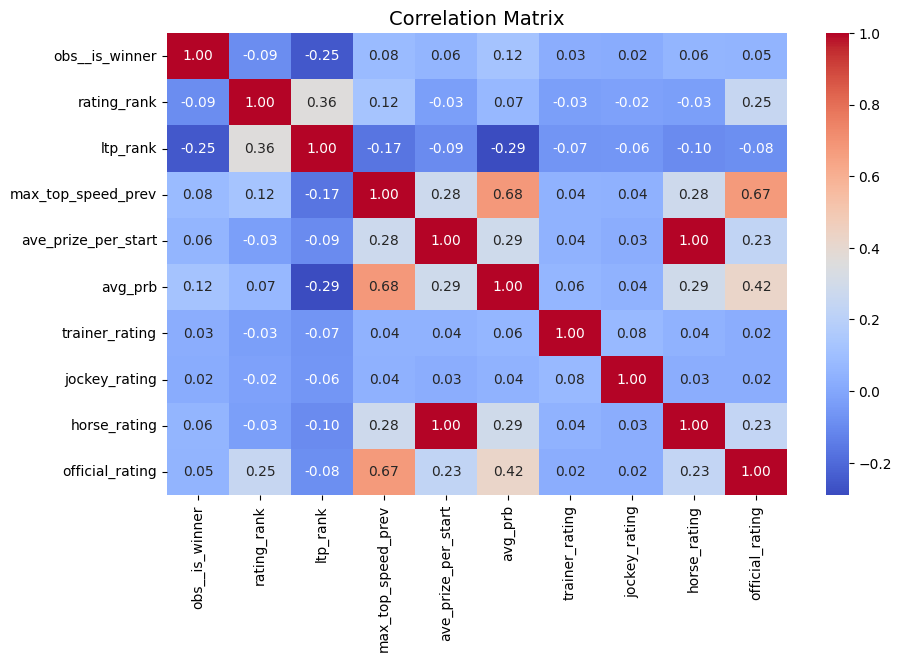

In [65]:
subset_cols = ['obs__is_winner', 'rating_rank', 'ltp_rank', 'max_top_speed_prev', 'ave_prize_per_start',
               'avg_prb', 'trainer_rating', 'jockey_rating', 'horse_rating', 'official_rating']

subset_df = df[subset_cols]

# Compute correlation matrix
corr_matrix = subset_df.corr()

# Display as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

### Create a training and testing dataset

In [ ]:
feature_cols = ['rating_rank', 'ltp_rank', 'max_top_speed_prev', 'ave_prize_per_start',
               'avg_prb', 'trainer_rating', 'jockey_rating', 'horse_rating']   
target = 'obs__is_winner'

train_data, test_data = split_data(df)

X_train = train_data[feature_cols]
y_train = train_data[target]
X_test = test_data[feature_cols]
y_test = test_data[target]

In [67]:
test_data.head()

,date,racecourse_country,racecourse_name,race_time,race_id,race_distance,race_type,race_type_simple,going_clean,n_runners,horse_id,horse_name,age,official_rating,carried_weight,draw,jockey_id,jockey_name,trainer_id,trainer_name,ltp_5min,obs__bsp,obs__racing_post_rating,obs__Place,obs__uposition,obs__is_winner,obs__top_speed,obs__distance_to_winner,obs__pos_prize,obs__completion_time,draw_iv,ltp_rank,rating_rank,max_top_speed_prev,horse_cum_prize_prev,horse_cum_starts_prev,ave_prize_per_start,prb,avg_prb,sp_pct,trainer_cum_actual,trainer_cum_expected,trainer_rating,jockey_cum_actual,jockey_cum_expected,jockey_rating,horse_rating
205,2015-05-01,GB,Lingfield,17:15,151376,1011.3264,Flat,Flat AW,Good,9,9310,Desert Strike,9,82.0,59.420600,8,5466,Hayley Turner,622,Conor Dore,10.50,11.95,78.0,4,4,0,50.0,3.25,348.73,59.32,0.972678,4.0,3.0,0.0,0.0,0,0.0,0.625,0.0,0.077220,0.0,0.000000,0.000000,0.0,0.026399,0.000000,0.0
206,2015-05-01,GB,Lingfield,17:15,151376,1011.3264,Flat,Flat AW,Good,9,13992,Fine 'n Dandy,4,84.0,60.327785,3,5536,Jamie Spencer,241,J R Jenkins,22.00,20.00,38.0,9,9,0,9.0,15.05,0.00,61.29,1.051659,8.0,1.0,0.0,0.0,0,0.0,0.000,0.0,0.047619,1.0,0.108887,9.183829,0.0,0.549410,0.000000,0.0
207,2015-05-01,GB,Lingfield,17:15,151376,1011.3264,Flat,Flat AW,Good,9,14241,Sandfrankskipsgo,6,84.0,60.327785,4,7328,George Baker,757,Peter Crate,2.88,3.10,88.0,2,2,0,60.0,1.00,1395.62,58.95,1.243789,1.0,1.0,0.0,0.0,0,0.0,0.875,0.0,0.243902,0.0,0.196078,0.000000,0.0,0.395824,0.000000,0.0
208,2015-05-01,GB,Lingfield,17:15,151376,1011.3264,Flat,Flat AW,Good,9,69165,Wahaab,4,82.0,59.420600,1,1113,Kieran O'Neill,771,Ken Cunningham-Brown,15.00,8.87,63.0,7,7,0,35.0,7.55,0.00,60.04,0.950420,5.0,3.0,0.0,0.0,0,0.0,0.250,0.0,0.101317,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
209,2015-05-01,GB,Lingfield,17:15,151376,1011.3264,Flat,Flat AW,Good,9,89675,Pearl Noir,5,72.0,54.884677,6,264,Luke Morris,82,Scott Dixon,8.00,8.20,51.0,8,8,0,23.0,8.05,0.00,60.12,0.853364,3.0,7.0,0.0,0.0,0,0.0,0.125,0.0,0.108696,0.0,0.000000,0.000000,1.0,0.557482,1.793781,0.0


### Start with a baseline model.
- Our baseline model is going to be simply backing every market favourite using 'obs__bsp'. Over the long term, ~33% of the time the favourite wins (flat racing). From my experience it is a fairly popular system and there is a cohort of professional gamblers who only back favourites.

In [69]:
test_dataBL = test_data.copy()

y_predBL = test_dataBL['obs__is_winner']
test_dataBL['model_preds'] = y_predBL

In [70]:
print_metrics(y_test, y_predBL)
print()
profit_calculation(test_dataBL)


Confusion Matrix: 
[[139701      0]
 [     0  16362]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
ROC AUC score: 1.0

Total number of bets: 16362
Total return from betting £1.00 on each prediction where model_preds == 1: £136147.83
Return per pound invested: £8.32
Model accuracy: 100.00%


In [ ]:
# Calculate profit for £1 bet on favourites
test_data['fav_profit'] = 0.0
test_data.loc[test_data['is_fav'] & (test_data['obs__is_winner'] == 1), 'fav_profit'] = df['obs__bsp'] -1
test_data.loc[test_data['is_fav'] & (test_data['obs__is_winner'] == 0), 'fav_profit'] = -1

# Total profit
total_profit = test_data['fav_profit'].sum()

# Step 4: ROI
n_bets = test_data['is_fav'].sum()
roi = total_profit / n_bets

print(f"Total Profit: £{total_profit:.2f}")
print(f"ROI per £1 staked: {roi:.2%}")


Total Profit: £-100.44
ROI per £1 staked: -0.61%


/var/folders/nv/lzp9ffbj6cs24kjrpcj0q1ym0000gn/T/ipykernel_82209/1087663905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['is_fav'] = test_data.groupby('race_id')['obs__bsp'].transform(lambda x: x == x.min())
/var/folders/nv/lzp9ffbj6cs24kjrpcj0q1ym0000gn/T/ipykernel_82209/1087663905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['fav_profit'] = 0.0


Train a gradient booster classifier

In [53]:
test_data1 = test_data.copy()

gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_classifier.predict(X_test)

test_data1['model_preds'] = y_pred_gb


In [59]:
print_metrics(y_test, y_pred_gb)
print()
profit_calculation(test_data1)


Confusion Matrix: 
[[139654     47]
 [ 16303     59]]
Accuracy: 0.8952346167893735
Precision: 0.5566037735849056
Recall: 0.0036059161471702727
F1 score: 0.007165411707554044
ROC AUC score: 0.5016347416685487

Total number of bets: 106
Total return from betting £1.00 on each prediction where model_preds == 1: £-5.12
Return per pound invested: £-0.05
Model accuracy: 55.66%


### Dealing with an imbalanced dataset.
- It is important to note the imbalanced nature of this dataset when using 'obs__is_winner' as the dependent variable.
In the vast majority of race there is only one winner with multiple losers.
- I will look at utilizing random oversampling to see if that improves the predictive power of 
the gradient booster classifier.

In [61]:
# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(f"Length of  X_train: {len(X_train)}\nLength of y_train: {len(y_train)}")
print(f"\nLength of  X_resampled: {len(X_resampled)}\nLength of y_resampled: {len(y_resampled)}")

Length of  X_train: 621486
Length of y_train: 621486

Length of  X_resampled: 1112080
Length of y_resampled: 1112080


In [64]:
# Instantiate and train the Gradient Boosting classifier
test_data2 = test_data.copy()

gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_gbx = gb_classifier.predict(X_test)

test_data2['model_preds'] = y_pred_gbx

In [63]:
print_metrics(y_test, y_pred_gb)
print()
profit_calculation(test_data2)


Confusion Matrix: 
[[139654     47]
 [ 16303     59]]
Accuracy: 0.8952346167893735
Precision: 0.5566037735849056
Recall: 0.0036059161471702727
F1 score: 0.007165411707554044
ROC AUC score: 0.5016347416685487

Total number of bets: 51935
Total return from betting £1.00 on each prediction where model_preds == 1: £-423.40
Return per pound invested: £-0.01
Model accuracy: 21.87%


### Monte carlo simulations
- Monte carlo simulations are an important tool to help simulate betting scenarios. Using monte carlo simulations we can look at the distribution of returns rather than a single point estimate. Monet carlo simulations help measure expected profitability and risk. Risk is very important as all systems will go through losing steaks, even with a positive edge and short term variance can wipe out a 'betting bank'.
- Monte carlo allows models to be simulated 'n' number of times allowing us to see how long losing runs may go, the profitability of increasing stake size and the risk of ruin.

Average ROI: -0.0173
ROI Std Dev: 0.0136


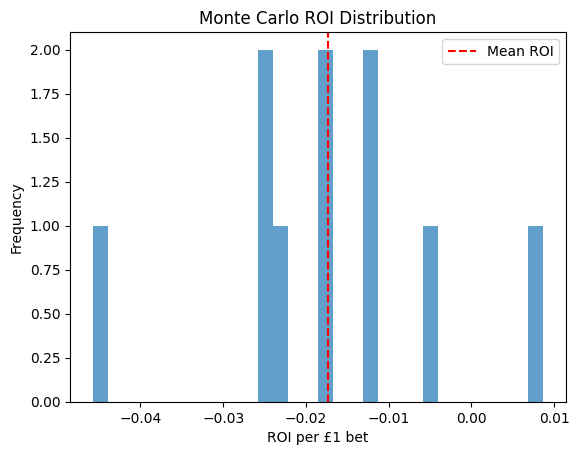

In [44]:
mean_roi, std_roi, roi_dist = monte_carlo_simulation(df, feature_cols, n_sims=10)

print(f"Average ROI: {mean_roi:.4f}")
print(f"ROI Std Dev: {std_roi:.4f}")

# Plot ROI distribution
plt.hist(roi_dist, bins=30, alpha=0.7)
plt.axvline(mean_roi, color="red", linestyle="--", label="Mean ROI")
plt.title("Monte Carlo ROI Distribution")
plt.xlabel("ROI per £1 bet")
plt.ylabel("Frequency")
plt.legend()
plt.show()
